# Fraud Detection Using Machine Learning

For this analysis I used the Paysim dataset. 'PaySim simulates mobile money transactions based on a sample of real transactions extracted from one month of financial logs from a mobile money service implemented in an African country. The original logs were provided by a multinational company, who is the provider of the mobile financial service which is currently running in more than 14 countries all around the world.'
Note: Data pre-processing was simplified for this project as my goal was to improve my knowledge of neural network application in Pytorch.


# The variables provided are as follows
1. step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).
2. type - type of transaction : CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.
3. amount - amount of the transaction in local currency.
4. nameOrig - customer who started the transaction
5. oldbalanceOrg - initial balance before the transaction
6. newbalanceOrig - new balance after the transaction
7. nameDest - customer who is the recipient of the transaction
8. oldbalanceDest - initial balance recipient before the transaction. 
9. newbalanceDest - new balance recipient after the transaction. 
10. isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.
11. isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction


In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

import torch

import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torch.utils.data as Data

from sklearn.model_selection import train_test_split
from sklearn import metrics

__Load the data and print out the top 5 entries__

In [2]:
data = pd.read_csv('paysim.csv')

In [3]:
print('Number of entries: {}'.format(len(data)))
print('Number of fraudulent transactions: ', data['isFraud'].sum())
data.head(5)

Number of entries: 6362620
Number of fraudulent transactions:  8213


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


As we can see, the dataset is over 6,000,000 entries in length with only 8213 of those being fraudulent transactions. In order to get accurate testing and training we need to have a more even balance of fraudulent and non-fraudulent transactions.

For example, consider testing a model on the dataset as it stands. If the model were to predict every transaction as non-fraudulent it would actually correctly predict 99.87% of cases while being utterly useless to the user.

And so, we must creat a new dataset with a more even proportion. (Note: This is a simplistic approach to solving this problem)

In [4]:
# Firstly create a dataframe containing only the fraudulent transactions
fraud = data[data['isFraud'] == 1]

# Similary for non-fraudulent
non_fraud = data[data['isFraud'] == 0]

# Now take a random sample from the non_fraud data of size equal to the size of the fraudulent data
non_fraud = non_fraud.sample(n=len(fraud))
#non_fraud = non_fraud.sample(n=50000)

# Now combine the two dataframes
# This will yield a dataframe with half fraudulent and half non-fraudulent transactions as required
new_data = pd.concat([fraud, non_fraud])

# Randomise the order of entries
new_data = new_data.sample(frac=1)

print(len(new_data))
new_data.head()

16426


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2146700,184,CASH_IN,15799.81,C801883900,1810386.28,1826186.10,C730999562,1202560.38,1186760.56,0,0
790064,40,CASH_OUT,280378.73,C71180095,105100.00,0.00,C372682046,0.00,372907.54,0,0
6186780,568,CASH_OUT,30790.13,C642401754,30790.13,0.00,C1650668671,148453.03,179243.16,1,0
3880925,283,CASH_IN,252165.57,C1314948667,208701.00,460866.57,C732219295,72918.72,0.00,0,0
2127411,183,CASH_IN,83851.62,C1042939419,2383332.86,2467184.49,C1542088744,117507.82,33656.20,0,0


# Data preperation for use training model
1. Remove useless variables
2. One-hot encode categorical variables

## 1. Remove useless variables

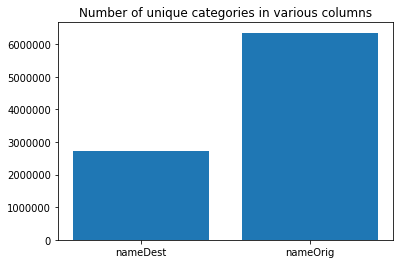

In [5]:
labels = ['nameOrig', 'nameDest']
counts = []
for i in labels:
    counts.append(len(data[i].unique()))

plt.bar(labels, counts)
plt.title('Number of unique categories in various columns')
plt.show()

1. nameOrig - this variable has too many unique categories, as can be seen above, and so is not a useful predictor
2. nameDest - can be dropped for same reasoning
3. isFlaggedFraud - Remove since this is our target
4. step - This variable could be a useful predictor however it would have to be one-hot encoded into bins of 6 hour intervals for example. We will not be doing this here and so we drop it

Note: nameOrig and nameDest could be useful if we were given more info that would allow us to put them into a reasonable number of categories for one-hot encoding. 
For example: If we knew that nameOrig values staring with 'C1' meant something different to those starting with 'C2'  we could one-hot encode but we are not told any extra information in this case and so we can drop it.

In [6]:
new_data.drop(['nameOrig'], axis = 1, inplace = True)
new_data.drop(['nameDest'], axis = 1, inplace = True)
new_data.drop(['isFlaggedFraud'], axis = 1, inplace = True)
new_data.drop(['step'], axis = 1, inplace = True)

## 2. One-hot encode categorical variables
In this case, the _type_ variable can be one-hot encoded into 5 categories;
1. Cash_Out
2. Cash_In
3. Debit
4. Payment
5. Transfer

In [7]:
"""
One hot encoding:
    We want it so that there is a new column for each type of payment listed above
    In each column we want a 1 if this is the type of payment listed and 0 otherwise
"""

#This for loop will create the columns with a True or False value in them
for payment_type in new_data.type.unique():
    new_data[payment_type] = new_data['type'] == payment_type

# Now we convert these True/False values to 1 or 0
for payment_type in new_data.type.unique():
    new_data[payment_type] = np.where(new_data[payment_type] == True, 1, 0)

#Now we can remove the type column
new_data.drop(['type'], axis = 1, inplace = True)

In [8]:
new_data.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,CASH_IN,CASH_OUT,PAYMENT,TRANSFER,DEBIT
2146700,15799.81,1810386.28,1826186.10,1202560.38,1186760.56,0,1,0,0,0,0
790064,280378.73,105100.00,0.00,0.00,372907.54,0,0,1,0,0,0
6186780,30790.13,30790.13,0.00,148453.03,179243.16,1,0,1,0,0,0
3880925,252165.57,208701.00,460866.57,72918.72,0.00,0,1,0,0,0,0
2127411,83851.62,2383332.86,2467184.49,117507.82,33656.20,0,1,0,0,0,0


# Formatting the Data for use in Pytorch model
Now that the data has been processed and only the variables we need remain we need to convert our data to tensors and then create DataLoaders so that the model knows which are the target variables and which are the predictor variables.

In [9]:
train, test = train_test_split(new_data, test_size=0.3)

train_targets = train.as_matrix(columns = ['isFraud'])
train_predictors = train.drop(['isFraud'], axis = 1)
train_predictors = train_predictors.as_matrix()

test_targets = test.as_matrix(columns = ['isFraud'])
test_predictors = test.drop(['isFraud'], axis=1)
test_predictors = test_predictors.as_matrix()

train_targets = torch.tensor(train_targets)
train_predictors = torch.tensor(train_predictors)

test_targets = torch.tensor(test_targets)
test_predictors = torch.tensor(test_predictors)

# TrainLoader
torch_dataset = Data.TensorDataset(train_predictors, train_targets)
BATCH_SIZE = 60
trainloader = Data.DataLoader(
    dataset = torch_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = 2)

# Validation loader
torch_dataset = Data.TensorDataset(test_predictors, test_targets)
BATCH_SIZE = 60
validloader = Data.DataLoader(
    dataset=torch_dataset,      # torch TensorDataset format
    batch_size=BATCH_SIZE,      # mini batch size
    shuffle=True,               # random shuffle for training
    num_workers=2,              # subprocesses for loading data
)

In [10]:
print(type(train_predictors))
print(type(trainloader))

<class 'torch.Tensor'>
<class 'torch.utils.data.dataloader.DataLoader'>


In [11]:
for step, (batch_x, batch_y) in enumerate(trainloader):
    print(type(batch_x))
    break

<class 'torch.Tensor'>


# Define a function to build the model / network

We allow for a specified number of hidden layers and also incorporate dropout to try and prevent overfitting of the training data.

In [12]:
class Network(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, drop_p=0.5):
        ''' Builds a feedforward network with arbitrary hidden layers.
        
            Arguments
            ---------
            input_size: integer, size of the input
            output_size: integer, size of the output layer
            hidden_layers: list of integers, the sizes of the hidden layers
            drop_p: float between 0 and 1, dropout probability
        '''
        super().__init__()
        # Add the first layer, input to a hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        
        # Add a variable number of more hidden layers
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        
        self.output = nn.Linear(hidden_layers[-1], output_size)
        
        self.dropout = nn.Dropout(p=drop_p)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        
        # Forward through each layer in `hidden_layers`, with ReLU activation and dropout
        for linear in self.hidden_layers:
            x = F.relu(linear(x))
            x = self.dropout(x)
        
        x = self.output(x)
        
        return F.sigmoid(x)

# Define a function to test the accuracy of the model

In [13]:
def validation(model, loader, criterion):
    device='cpu'
    model.to(device)
    test_loss = 0
    accuracy = 0
    for step, (batch_x, batch_y) in enumerate(loader):
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        batch_x = batch_x.float()
        batch_y = batch_y.long().squeeze()
        #batch_x.resize_(batch_x.shape[0], 150528)

        output = model.forward(batch_x)
        test_loss += criterion(output, batch_y).item()

        ps = torch.exp(output)
        equality = (batch_y.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return test_loss, accuracy

# Create the model using the Network function defined above
__Network(1,2,3)__
1. There are 10 inputs (can be seen by checking the shape of the predictors tensor)
2. We want two outputs (Probability of not fraudulent and probability of fraudulent)
3. The hidden layers are entered as a list (can be experimented with to find best results)

__Criterion__

Using cross entropy loss in this case

__Optimiser__

Using the Adam optimiser in this case with a learning rate of 0.001 (Can be experimented with)

In [14]:
new_model = Network(10, 2, [50,25,10])
criterion = nn.CrossEntropyLoss()
optimiser = optim.Adam(new_model.parameters(), lr=0.001)

# Train the model

Epoch: 1/150..  Training Loss: 0.000..  Test Loss: 0.693..  Test Accuracy: 0.503
Epoch: 14/150..  Training Loss: 0.001..  Test Loss: 0.629..  Test Accuracy: 0.501
Epoch: 27/150..  Training Loss: 0.002..  Test Loss: 0.809..  Test Accuracy: 0.504
Epoch: 40/150..  Training Loss: 0.003..  Test Loss: 0.812..  Test Accuracy: 0.501
Epoch: 53/150..  Training Loss: 0.004..  Test Loss: 0.469..  Test Accuracy: 0.816
Epoch: 66/150..  Training Loss: 0.005..  Test Loss: 0.432..  Test Accuracy: 0.880
Epoch: 79/150..  Training Loss: 0.005..  Test Loss: 0.421..  Test Accuracy: 0.887
Epoch: 92/150..  Training Loss: 0.006..  Test Loss: 0.420..  Test Accuracy: 0.891
Epoch: 105/150..  Training Loss: 0.007..  Test Loss: 0.421..  Test Accuracy: 0.892
Epoch: 118/150..  Training Loss: 0.008..  Test Loss: 0.400..  Test Accuracy: 0.904
Epoch: 131/150..  Training Loss: 0.008..  Test Loss: 0.413..  Test Accuracy: 0.899
Epoch: 144/150..  Training Loss: 0.009..  Test Loss: 0.409..  Test Accuracy: 0.903


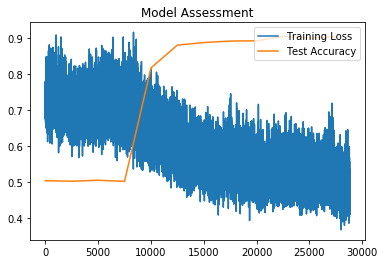

In [15]:
num_epochs = 150
epochs = num_epochs
print_every = 2500
steps = 0
device = 'cpu'

loss_values = []
step_values = []
count_values = []
accuracy_values = []

for e in range(epochs):
    running_loss = 0

    for step, (batch_x, batch_y) in enumerate(trainloader): 
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        batch_x = batch_x.float()
        batch_y = batch_y.long()
        steps += 1
        optimiser.zero_grad()
        output = new_model.forward(batch_x)
        
        #print(output.size())
        #print(batch_y.squeeze().size())
        #break
        loss = criterion(output, batch_y.squeeze())
        loss.backward()
        optimiser.step()
        
        loss_values.append(loss.item())
        step_values.append(steps)
        running_loss += loss.item()

        if steps % print_every == 0 or steps==1:
            # Make sure network is in eval mode for inference
            new_model.eval()

            # Turn off gradients for validation, saves memory and computations
            with torch.no_grad():
                test_loss, accuracy = validation(new_model, validloader, criterion)
                count_values.append(steps)
                accuracy_values.append(accuracy/len(validloader))
            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                  "Test Loss: {:.3f}.. ".format(test_loss/len(validloader)),
                  "Test Accuracy: {:.3f}".format(accuracy/len(validloader)))

            running_loss = 0

            # Make sure training is back on
            new_model.train()

plt.plot(step_values, loss_values, label = 'Training Loss')
plt.plot(count_values, accuracy_values, label = 'Test Accuracy')
plt.legend(loc='upper right')
plt.title('Model Assessment')
plt.show()

As can be seen above, the test accuracy starts off around 50%. This makes sense since on the first pass the weights are random and so the model is essentially making a 50:50 guess at the data and since we have constructed the training data to be half fraudulent and half non fraudulent we should see a test accuracy in the vicinity of 50% on the first pass.

From here the accuracy increases substantially as the weights are updated via the training process.

# Test trained model on original data

Now we want to test the trained model on the original data and see how it does in classifying fraud and non-fraud data.
Firstly, we carry out the same data preprocessing as above on all of the data.

In [16]:
data.drop(['nameOrig'], axis = 1, inplace = True)
data.drop(['nameDest'], axis = 1, inplace = True)
data.drop(['isFlaggedFraud'], axis = 1, inplace = True)
data.drop(['step'], axis = 1, inplace = True)

for payment_type in data.type.unique():
    data[payment_type] = data['type'] == payment_type

for payment_type in data.type.unique():
    data[payment_type] = np.where(data[payment_type] == True, 1, 0)

data.drop(['type'], axis = 1, inplace = True)

In [17]:
targets = data.as_matrix(columns = ['isFraud'])
predictors = data.drop(['isFraud'], axis = 1)
predictors = predictors.as_matrix()

targets = torch.tensor(targets)
predictors = torch.tensor(predictors)

# Loader
torch_dataset = Data.TensorDataset(predictors, targets)
BATCH_SIZE = 60
loader = Data.DataLoader(
    dataset = torch_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = 2)

In [21]:
new_model.eval()
with torch.no_grad():
    test_loss, accuracy = validation(new_model,loader,criterion)
    print("Test Loss: {:.3f}.. ".format(test_loss/len(loader)),
          "Test Accuracy: {:.3f}".format(accuracy/len(loader)))
    

Test Loss: 0.353..  Test Accuracy: 0.963


Now we can see that our test Accuracy on the data is very high. Although it is not as high as if the model just guessed non-fraud every time, so why is it useful?

Well, in this case, a bank or account holder would much much rather a model catch the fraud cases even if it means over flagging fraudulent transactions as the impact of a non-fraudulent transaction being flagged as fraudulent is minimal while a fraudulent transaction being missed would have much larger ramifications.

To see how well our model classifies fraudulent transactions we will now test the model on only the fraudulent transactions.

# Test model on only fraud data

In [18]:
fraudulent = data[data['isFraud']==1]
targets = fraudulent.as_matrix(columns = ['isFraud'])
predictors = fraudulent.drop(['isFraud'], axis = 1)
predictors = predictors.as_matrix()

targets = torch.tensor(targets)
predictors = torch.tensor(predictors)

# TrainLoader
torch_dataset = Data.TensorDataset(predictors, targets)
BATCH_SIZE = 60
fraudloader = Data.DataLoader(
    dataset = torch_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = 2)

In [19]:
new_model.eval()
with torch.no_grad():
    test_loss, accuracy = validation(new_model,fraudloader,criterion)
    print("Test Loss: {:.3f}.. ".format(test_loss/len(fraudloader)),
          "Test Accuracy: {:.3f}".format(accuracy/len(fraudloader)))
    

Test Loss: 0.447..  Test Accuracy: 0.862


# Conclusion

From the above we can see that the model successfully classifies 96% of transactions, however, more importantly it successfully classifies 86.2% of fraudulent transactions. This high percentage could make it an extremely useful tool in detecting fraudulent transactions.

### Additional Notes

As this was an exercise in applying a neural network through Pytorch the feature engineering is minimal and the results could undoubtedly be improved through further engineering.